<font size="5">Section 6: Structural Equation Modelling</font>

## Housekeeping and Data

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
import linearmodels.panel as lmp
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
import semopy 
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA

%matplotlib inline

First, we simulate some data to use all different methods. Nine continuous variables and nine binary variables, all with different levels of correlation among them.

In [41]:
df_junaeb=pd.read_csv('../data/junaeb2.csv')
#data description
df=df_junaeb[['sk1','sk2','sk3','sk4','sk5','sk6','sk7','sk8','sk9','sk10','sk11','sk12','sk13']]
df.describe()


,sk1,sk2,sk3,sk4,sk5,sk6,sk7,sk8,sk9,sk10,sk11,sk12,sk13
count,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000
mean,1.117958,1.397310,1.270129,1.263129,1.275935,1.497372,2.257251,1.565490,1.346920,1.887275,1.397620,1.511158,1.715941
std,0.401019,0.661753,0.594456,0.588868,0.575344,0.746918,1.225424,0.846327,0.682243,0.959059,0.684203,0.811187,1.002515
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


<AxesSubplot:>

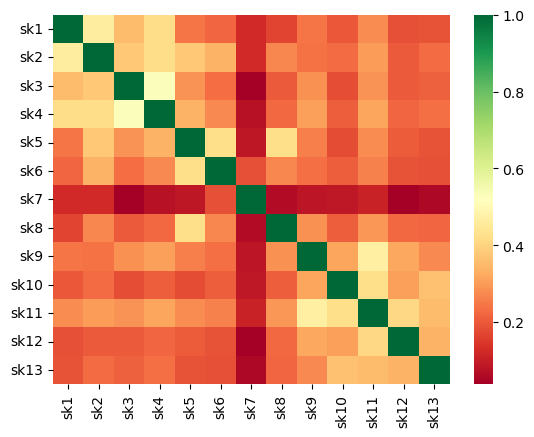

In [42]:
sns.heatmap(df.corr(), cmap='RdYlGn')

In [43]:
df['sk7'] = df['sk7'].map({1:5, 2:4, 3:3, 4:2, 5:1})
df.describe()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sk1,sk2,sk3,sk4,sk5,sk6,sk7,sk8,sk9,sk10,sk11,sk12,sk13
count,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000
mean,1.117958,1.397310,1.270129,1.263129,1.275935,1.497372,3.742749,1.565490,1.346920,1.887275,1.397620,1.511158,1.715941
std,0.401019,0.661753,0.594456,0.588868,0.575344,0.746918,1.225424,0.846327,0.682243,0.959059,0.684203,0.811187,1.002515
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
75%,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,5.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## PCA

PCA for continous variables in this example using sklearn. We can select the number of components to be estimated or use *'mle'* to determine the optimal number of eigenvalues based on the variance of the data.

Then we can report the Scree Plot that shows the percentage of variance that each component contributes. Based on the results, the data can be summarized using three components.

Finally, we can use the estimated components and transform them into a data frame. We can also show that, by construction, the components are orthogonal (zero covariance).

In [46]:
pca = PCA(n_components=13)
pca_features = pca.fit_transform(df)
print(pca.explained_variance_ratio_)

[0.29450426 0.18238083 0.09977177 0.07810933 0.06612721 0.06382277
 0.05132906 0.04380861 0.03221139 0.02940447 0.02458364 0.02070721
 0.01323945]


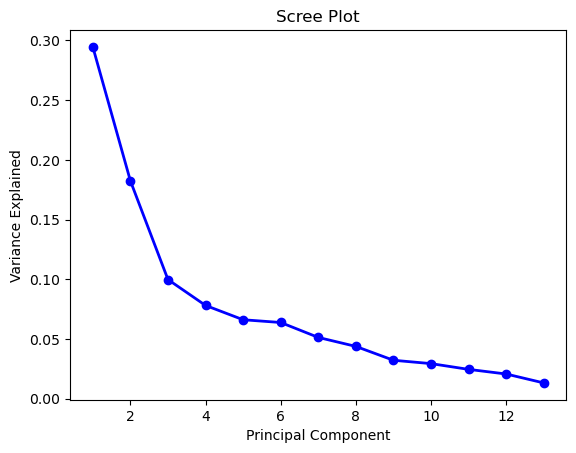

In [47]:
#scree plot using explained variance proportion

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [51]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(df)
print(pca.explained_variance_ratio_)

[0.29450426 0.18238083 0.09977177]


In [52]:
pca_vectors = pd.DataFrame(data = pca.components_)
pca_vectors.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.113209,0.231651,0.178868,0.196377,0.188830,0.252432,-0.295672,0.291301,0.254798,0.408116,0.297746,0.297981,0.427062
1,0.005312,0.019484,0.060142,0.049555,0.032669,-0.043421,0.942059,0.086491,0.075394,0.141323,0.084334,0.142029,0.206565
2,0.090250,0.264741,0.195768,0.201958,0.296426,0.326628,0.112161,0.453620,0.082935,-0.387114,0.003397,-0.095241,-0.513743


In [53]:
pca_df = pd.DataFrame(data=pca_features,columns=['PC1', 'PC2', 'PC3'])
pca_df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,PC1,PC2,PC3
count,41854.000,41854.000,41854.000
mean,0.000,-0.000,0.000
std,1.527,1.202,0.889
min,-1.946,-3.237,-3.904
25%,-1.128,-0.755,-0.476
50%,-0.286,0.175,0.036
75%,0.811,0.847,0.467
max,11.790,4.144,5.868


In [54]:
pca_df.corr().apply(lambda s: s.apply('{0:.3f}'.format))

,PC1,PC2,PC3
PC1,1.000,-0.000,0.000
PC2,-0.000,1.000,-0.000
PC3,0.000,-0.000,1.000


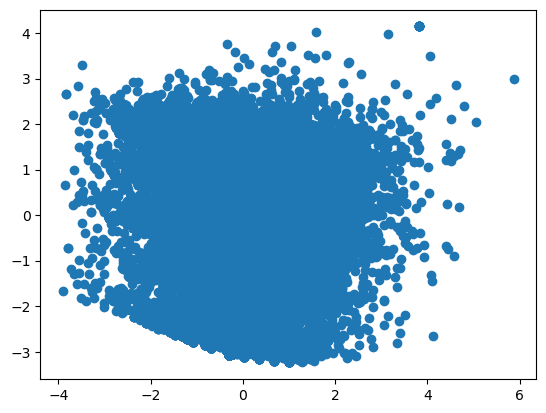

In [56]:
plt.scatter(pca_df['PC3'],pca_df['PC2'])

## EFA

EFA example using factor_analyzer library. Output shows the factor loadings for each factor, and the eigenvalues, which can be used to construct a scree plot. Number of factors can be chosen or estimated optimally from the data.

Using the semopy library we can also infer which variables belong to each factor, based on the estimated factor loadings (criteria does not restrict unique loadings to each factor). Estimated number of factors chosen optimally base on the data.

Note that semopy yields less factors than factor_analyzer. The difference is due that factor_analyzer reports factors until eigenvalues are irrelevant (variance explained), while semopy presents a potential EFA where all coeficients are statistically significant. In this case, the third factor is mainly only loading to X1 an it contributes to a small proportion of the total explained variance.

Finally semopy reports that the variance-covariance matrix in the dataframe is not positive definite, meaning that some variables are highly correlated (as expected by design), meaning that estimates are likely to be untrustworty. 

In [59]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation='promax')
fa.fit(df)

FactorAnalyzer(rotation_kwargs={})

In [123]:
fa.loadings_

array([[-0.03487373,  0.10548121,  1.00328716],
       [-0.44951466,  1.06187463,  0.02031994],
       [-0.96047954, -0.10836013,  0.08990928],
       [-0.62984551, -0.58164478,  0.1333002 ],
       [ 1.06947595, -0.31256919, -0.08802168],
       [ 0.55073345,  0.65903813,  0.10388396],
       [ 0.93675305,  0.15881277, -0.08485118],
       [ 0.96605162, -0.24462346,  0.31648911],
       [ 0.09092536,  0.96582186,  0.07345973]])

In [60]:
fa.get_eigenvalues()

(array([4.15426624, 1.33653327, 1.0990827 , 0.99949323, 0.77208669,
        0.70112662, 0.69212732, 0.68408107, 0.59661363, 0.51552398,
        0.50583288, 0.48741185, 0.45582053]),
 array([ 3.57232658,  0.75916373,  0.60709027,  0.21152932,  0.08846197,
         0.06143919,  0.03102822,  0.02496555, -0.02566573, -0.06861802,
        -0.1014971 , -0.12296062, -0.17587892]))

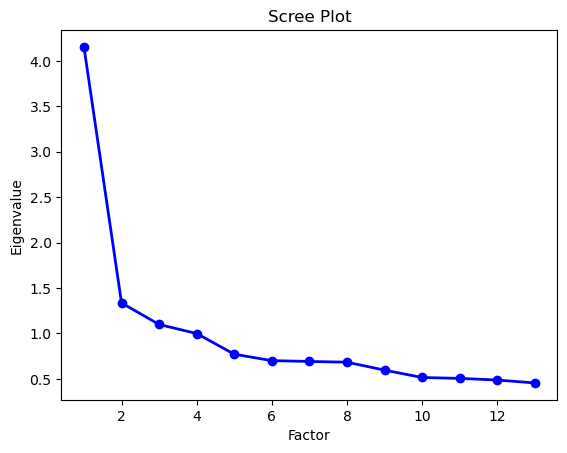

In [63]:
values = np.arange(1,14)
eigenvalues = pd.DataFrame(data=fa.get_eigenvalues())
plt.plot(values, eigenvalues.loc[0], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.show()

In [64]:
fa.get_factor_variance()

(array([1.79982977, 1.66952159, 1.39203307]),
 array([0.13844844, 0.12842474, 0.10707947]),
 array([0.13844844, 0.26687318, 0.37395265]))

EFA example using semopy

In [65]:
print(semopy.efa.explore_cfa_model(df, pval=0.05))

eta1 =~ sk11 + sk9 + sk10 + sk12
eta2 =~ sk6 + sk7
eta3 =~ sk4 + sk2 + sk11 + sk5 + sk3 + sk9 + sk1 + sk8 + sk12
eta4 =~ sk11 + sk12 + sk13



## Latent clases

R package adapted for Python can be used, called stepmix (install with pip)

In [69]:
from stepmix.stepmix import StepMix

# Continuous StepMix Model with 3 latent classes
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123)

# Fit model and predict clusters
model.fit(df)
df['pred']=model.predict(df)

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 13 features, each with 6 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 6 are associated with the first feature,
        columns 7 to 12 are associated with the second feature, etc.

        Class 1 : [0.0000 0.9857 0.0093 0.0038 0.0005 0.0007 0.0000 0.9012 0.0741 0.0211
 0.0020 0.0016 0.0000 0.9379 0.0373 0.0200 0.0026 0.0022 0.0000 0.9611
 0.0230 0.0123 0.0015 0.0019 0.0000 0.9521 0.0294 0.0163 0.0015 0.0007
 0.0000 0.8403 0.1103 0.0353 0.0070 0.0070 0.0000 0.0988 0.0392 0.1786
 0.2360 0.4475 0.0000 0.8494 0.0835 0.0436 0.0114 0.0120 0.0000 0.9371
 0.0365 0.0195 0.0040 0.0029 0.0000 0.6633 0.1738 0.1326 0.0196 0.0107
 0.0000 0.9494 0.0301 0.0153 0.0031 0.0021 0.0000 0.8795 0.0653 0.0398
 0.0088 0.0066 0.0000 0.7982 0.0896 0.0729 0.0212 0.0181]
        Class

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
df.describe()

,sk1,sk2,sk3,sk4,sk5,sk6,sk7,sk8,sk9,sk10,sk11,sk12,sk13,pred
count,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000,41854.000000
mean,1.117958,1.397310,1.270129,1.263129,1.275935,1.497372,3.742749,1.565490,1.346920,1.887275,1.397620,1.511158,1.715941,0.862522
std,0.401019,0.661753,0.594456,0.588868,0.575344,0.746918,1.225424,0.846327,0.682243,0.959059,0.684203,0.811187,1.002515,0.922212
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000
75%,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,5.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000


## Latent growth

Latent growth modelling is not available on Python at this time. Example available in R for the lavaan library at https://lavaan.ugent.be/tutorial/growth.html

Latent trajectory class (growth curves and class membership) is not available on Python at this time. Example available in R using the LCTMtools library at https://rstudio-pubs-static.s3.amazonaws.com/522393_3aa7f65898f8426e9c0a92d7971b619d.html.

## General CFA

Based on the EFA results we implement a CFA using the semopy library. We declare the model, just as the suggestion in section 3, as a model object, then we declare the model and fit using the data (variable X1 not included since is not used). The output shows the optimized value of the log-likelihood, number of iterations and estimation method used. 

First, note that measurements load into multiple factors, leading to interpretation issues (specially since variables correlate negatively with one factor and positively with the other). Secondly, we observe small covariance between factors, and substatial diferences in the residual error variance across measurements (particularly large error variance in X8). Finally, we can report the fit indices of the model, which allows to compare against alternative specifications in the data.

Also, if you install the graphviz package (and python-graphviz), you can provide a visualization of the estimated model using the semplot function.

In [72]:
mod = """
# measurement model
eta1 =~ sk9 + sk10 + sk11 + sk12 + sk13
eta2 =~ sk6 + sk5 + sk4 + sk3 + sk2 + sk1
    """

model = semopy.Model(mod)
out=model.fit(df)
print(out)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.189
Number of iterations: 33
Params: 1.317 1.223 1.081 1.271 0.867 1.147 1.045 1.228 0.661 0.624 0.248 0.106 0.730 0.236 0.432 0.295 0.214 0.459 0.181 0.216 0.170 0.095 0.126


In [73]:
model.inspect(mode='list', what="names", std_est=True)

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,sk9,~,eta1,1.000000,0.604821,-,-,-
1,sk10,~,eta1,1.316946,0.566751,0.014949,88.097091,0.0
2,sk11,~,eta1,1.222515,0.737343,0.011897,102.758778,0.0
3,sk12,~,eta1,1.081344,0.550081,0.012544,86.20747,0.0
4,sk13,~,eta1,1.271095,0.523253,0.015306,83.047507,0.0
5,sk6,~,eta2,1.000000,0.475601,-,-,-
6,sk5,~,eta2,0.866859,0.535296,0.011753,73.75948,0.0
7,sk4,~,eta2,1.146540,0.691761,0.013735,83.477968,0.0
8,sk3,~,eta2,1.045047,0.624593,0.013083,79.875534,0.0
9,sk2,~,eta2,1.227798,0.659164,0.015003,81.838792,0.0


In [74]:
semopy.calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,43,55,7911.630926,0.0,108526.24384,0.927459,0.927099,0.906755,0.927099,0.907215,0.066123,45.621941,244.386622,0.189029


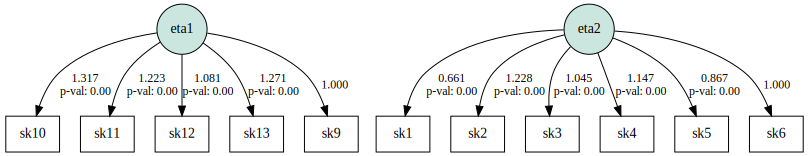

In [75]:
semopy.semplot(model, "model.png")

## Complete SEM example

SEM example considering both the measurement part and structural part in semopy (data and model provided at https://semopy.com/tutorial.html). This example presents a model where three factors are estimated from the data, where each measurement loads only into one factor. The first part of the model is as noted in section 6 (measurement only). Second part (regrssions) reports the structural relationships between factors, and the last part reports potential correlations between the error in each measure (this could be use in section 6 to improve final model). 

In [76]:
import semopy
import pandas as pd
desc = semopy.examples.political_democracy.get_model()
print(desc)

# measurement model
ind60 =~ x1 + x2 + x3
dem60 =~ y1 + y2 + y3 + y4
dem65 =~ y5 + y6 + y7 + y8
# regressions
dem60 ~ ind60
dem65 ~ ind60 + dem60
# residual correlations
y1 ~~ y5
y2 ~~ y4 + y6
y3 ~~ y7
y4 ~~ y8
y6 ~~ y8


In [77]:
data = semopy.examples.political_democracy.get_data()
mod = semopy.Model(desc)
res = mod.fit(data)

In [78]:
print(mod.inspect())

     lval  op   rval  Estimate  Std. Err    z-value   p-value
0   dem60   ~  ind60  1.482379  0.399024   3.715017  0.000203
1   dem65   ~  ind60  0.571912  0.221383   2.583364  0.009784
2   dem65   ~  dem60  0.837574  0.098446   8.507992       0.0
3      x1   ~  ind60  1.000000         -          -         -
4      x2   ~  ind60  2.180494  0.138565  15.736254       0.0
5      x3   ~  ind60  1.818546  0.151993   11.96465       0.0
6      y1   ~  dem60  1.000000         -          -         -
7      y2   ~  dem60  1.256819  0.182687   6.879647       0.0
8      y3   ~  dem60  1.058174  0.151521   6.983699       0.0
9      y4   ~  dem60  1.265186  0.145151   8.716344       0.0
10     y5   ~  dem65  1.000000         -          -         -
11     y6   ~  dem65  1.185743  0.168908   7.020032       0.0
12     y7   ~  dem65  1.279717  0.159996    7.99841       0.0
13     y8   ~  dem65  1.266084  0.158238   8.001141       0.0
14  dem60  ~~  dem60  3.950849  0.920451   4.292296  0.000018
15  dem6

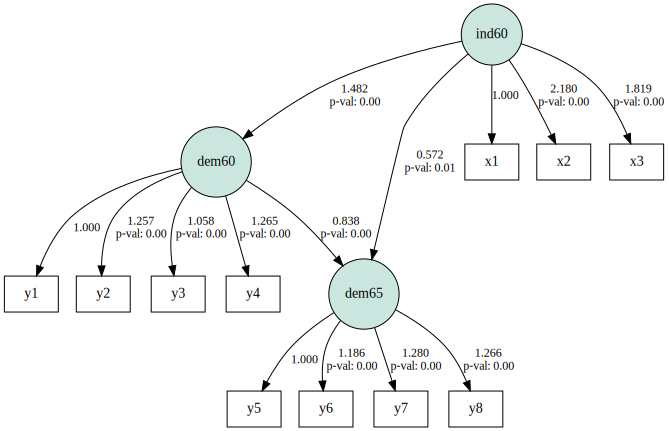

In [79]:
semopy.semplot(mod, "semmodel.png")

<font size="3">**Tarea 3**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 6/6 hasta las 21:00. Utilizar la base de datos *ifood_df.csv*. 

Preguntas:
